<a href="https://colab.research.google.com/github/beatlesatani/coding_september/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00


In [2]:
 pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 22.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ba02679b1be9684fa1e67b72de962d65dc2d4f62fd487496ea6a4f1100da7f26
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
import os
import shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from torch import nn, optim
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import defaultdict

In [4]:
#setup the dataset
test = 'https://raw.githubusercontent.com/beatlesatani/coding_september/main/test.csv'
train = "https://raw.githubusercontent.com/beatlesatani/coding_september/main/train.csv"
test = pd.read_csv(test,encoding='unicode_escape')
train = pd.read_csv(train,encoding='unicode_escape')
# remove unusuful columns
test = test.iloc[:,1:3]
train = train.iloc[:, [1,3]]
#check the insull values of train dataframe
train.isnull().sum()
#only one text is missing, so drop that low that incluse null cell
train = train.dropna()
#re-check null values
train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [5]:
#check the insull values of train dataframe
test.isnull().sum()

text         1281
sentiment    1281
dtype: int64

In [6]:
#afeter checking original csv file, all raws after 3533 is null
test = test.dropna()
#re-check null values
test.isnull().sum()

text         0
sentiment    0
dtype: int64

In [7]:
#check the label imbalance
train['sentiment'].value_counts(normalize=True)
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

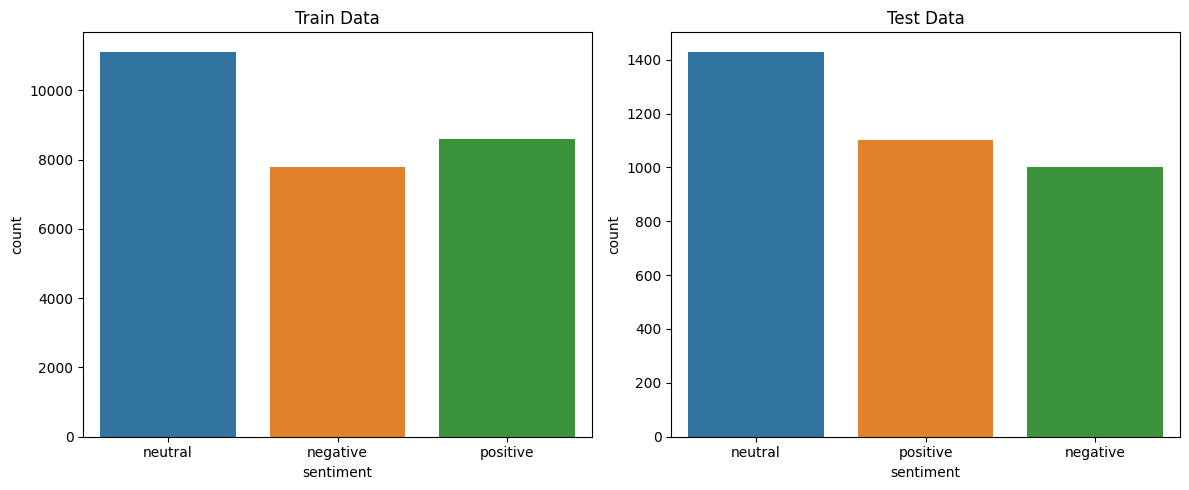

In [8]:
#graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='sentiment', data=train, ax=axes[0],saturation = 0.75)
axes[0].set_title('Train Data')

# Plot the countplot for 'sentiment' in the 'test' DataFrame
sns.countplot(x='sentiment', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()

In [9]:
'''
#before working to the model, convert labels into numerical number
train['label'] = train['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
train = train.drop('sentiment',axis = 1)
test['label'] = test['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
test = test.drop('sentiment',axis = 1)
'''
# Convert labels to integers: negative -> 0, neutral -> 1, positive -> 2
train['label'] = train['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
test['label'] = test['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})


In [10]:
#split the dataset
X_train = train['text']
y_train = train['label']
X_test = test['text']
y_test = test['label']

In [11]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((27480,), (27480,), (3534,), (3534,))

In [12]:
from transformers import BertTokenizer,TFBertModel,BertConfig,TFBertForSequenceClassification

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case = True)

In [15]:
sentence = train.iloc[0][0]
print('actual sentence:',sentence)
print("Tokeins : ",tokenizer.tokenize(sentence))
print("Token to ids:",tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

actual sentence:  I`d have responded, if I were going
Tokeins :  ['i', '`', 'd', 'have', 'responded', ',', 'if', 'i', 'were', 'going']
Token to ids: [1045, 1036, 1040, 2031, 5838, 1010, 2065, 1045, 2020, 2183]


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
<ipython-input-16-9c5678578d88>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


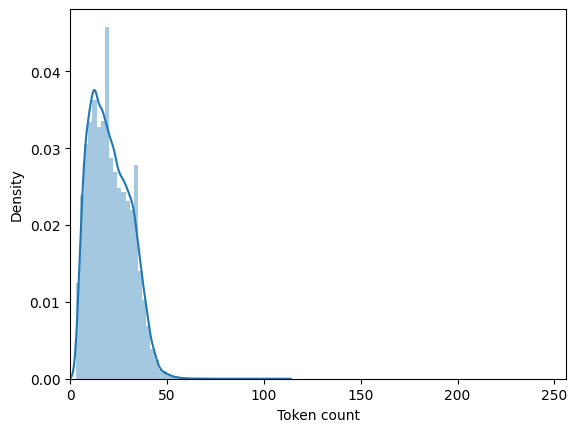

In [16]:
# to find the longest length, I gonna concat train,test
df = pd.concat([train,test])
token_lens = []

for txt in df["text"]:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

# I'll set max_len as 75
max_len = 75

In [28]:
'''
def mask_inputs_for_bert(tweets,max_len):
  #tokenize all of the sentences and map the tokens to their word IDS.
  input_ids = []
  attention_masks = []
  i = 0
  #for every sentence...
  for tweet in tweets:
    # what encode_plus do:
    # 1.tokenize the sentence.
    # 2. prepend the CLS token to the start of the sentences.
    # 3. append the SEP token to the end of the sentencnes
    # 4. map tokens to their ids.
    # 5. pad or truncate the sentence to 'max_length'
    # 6. create attention masks for PAD tokens.
    if (i<3):
      print("tweet",tweet)
      encoded_dict = tokenizer.encode_plus(
          tweet,
          add_special_tokens = True,
          max_length = max_len,
          pad_to_max_length = True,
          return_attention_mask = True
      )
      if(i<3):
        print("dict",encoded_dict['input_ids'])
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])
      i = i+1
    #convert to tensor (vector) and return
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    return input_ids, attention_masks
'''

def mask_inputs_for_bert(tweets, max_len):
    # Tokenize all of the sentences and map the tokens to their word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for tweet in tweets:
        # Encode the tweet using the tokenizer.
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists to tensors (vectors) and return
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)

    return input_ids, attention_masks

train_inp, train_mask = mask_inputs_for_bert(X_train, max_len)
val_inp, val_mask = mask_inputs_for_bert(X_test, max_len)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
train_inp,train_mask = mask_inputs_for_bert(X_train,max_len)
val_inp,val_mask = mask_inputs_for_bert(X_test,max_len)

In [30]:
train_label = tf.convert_to_tensor(y_train)
val_label = tf.convert_to_tensor(y_test)
#ここhone-hot-codingにした方がよい?
#train_label = tf.one_hot(train_label, depth=3)
#val_label = tf.one_hot(val_label, depth=3)


In [31]:
train_inp

<tf.Tensor: shape=(27480, 75), dtype=int32, numpy=
array([[  101,  1045,  1036, ...,     0,     0,     0],
       [  101, 17111,  2080, ...,     0,     0,     0],
       [  101,  2026,  5795, ...,     0,     0,     0],
       ...,
       [  101,  8038,  2100, ...,     0,     0,     0],
       [  101,  2021,  2009, ...,     0,     0,     0],
       [  101,  2035,  2023, ...,     0,     0,     0]], dtype=int32)>

In [32]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = 3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [34]:
import tensorflow as tf
from tensorflow import keras

# Define the paths and directory
log_dir = '/content/drive/My Drive/Colab_Notebooks'
model_save_path = '/content/drive/My Drive/Colab_Notebooks/bert_model.h5'
# Create the ModelCheckpoint callback
callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_save_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("Accuracy")
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon = 1e-08)

bert_model.compile(loss=loss, optimizer = optimizer,metrics = [metric])

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Bert Model None


In [ ]:
history = bert_model.fit([train_inp,train_mask],
                         train_label,
                         batch_size = 32,
                         epochs = 4,
                         validation_data = ([val_inp,val_mask],val_label),
                         callbacks = callbacks)

Epoch 1/4
  3/859 [..............................] - ETA: 6:29:45 - loss: 1.1286 - Accuracy: 0.2708